# Training RainNet

MIT License

Copyright (c) 2020 Georgy Ayzel

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

import gc

Define the dataset

In [ ]:
dataset = '../../data/datasets/example_dataset.npy'
val_dataset = '../../data/datasets/example_dataset.npy'

Create a data generator

In [2]:
import numpy as np
import keras
import gc
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,dataset,batch_size=4, frame=10, mode="train"):
        'Initialization'
        self.mode = mode
        self.frame = frame
        self.batch_inds = []
        self.dataset = dataset
        self.sequences = np.load(dataset, mmap_mode='r').shape[0] # mmap_mode='r' should only load the header
        #self.on_epoch_end()
        if batch_size > self.sequences:
            self.batch_size = int(np.ceil(self.sequences/2))
            print("Using batch_size {} instead of {}".format(self.batch_size,batch_size))
        else:
            self.batch_size = batch_size


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.sequences/self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        start_index = index * self.batch_size
        self.data = read_npy_chunk(self.dataset, start_index, self.batch_size)
        return self.__data_generation()

    def on_epoch_end(self):
        print("gc.collect()",gc.collect()) # if it's done something you should see a number being outputted
  
    def __data_generation(self):
        length = self.data.shape[1]
        
        self.encoder_input_data  = self.data[:, 0:self.frame,          :, :]/255.0
        self.decoder_input_data  = self.data[:, self.frame-1:length-1, :, :]/255.0
        self.decoder_output_data = self.data[:, self.frame:self.frame+1,     :, :]/255.0
        
        X = np.swapaxes(self.encoder_input_data, 1,3)
        Y = np.swapaxes(self.decoder_output_data, 1,3)

        self.data = []
        return X, Y
    
import struct
import numpy

def read_npy_chunk(filename, start_row, num_rows):
    assert start_row >= 0 and num_rows > 0
    with open(filename, 'rb') as fhandle:
        major, minor = numpy.lib.format.read_magic(fhandle)
        shape, fortran, dtype = numpy.lib.format.read_array_header_1_0(fhandle)
        assert not fortran, "Fortran order arrays not supported"
        # Make sure the offsets aren't invalid.
        assert start_row < shape[0], (
            'start_row is beyond end of file'
        )
        assert start_row + num_rows <= shape[0], (
            'start_row + num_rows > shape[0]'
        )
        # Get the number of elements in one 'row' by taking
        # a product over all other dimensions.
        row_size = numpy.prod(shape[1:])
        start_byte = start_row * row_size * dtype.itemsize
        fhandle.seek(start_byte, 1)
        n_items = row_size * num_rows
        flat = numpy.fromfile(fhandle, count=n_items, dtype=dtype)
        return flat.reshape((-1,) + shape[1:])

Define the model

In [3]:
def rainnet(input_shape=(64, 64, 16), mode="regression"):

    """
    The function for building the RainNet (v1.0) model from scratch
    using Keras functional API.
    Parameters:
    input size: tuple(W x H x C), where W (width) and H (height)
    describe spatial dimensions of input data (e.g., 928x928 for RY data);
    and C (channels) describes temporal (depth) dimension of 
    input data (e.g., 4 means accounting four latest radar scans at time
    t-15, t-10, t-5 minutes, and t)
    
    mode: "regression" (default) or "segmentation". 
    For "regression" mode the last activation function is linear, 
    while for "segmentation" it is sigmoid.
    To train RainNet to predict continuous precipitation intensities use 
    "regression" mode. 
    RainNet could be trained to predict the exceedance of specific intensity 
    thresholds. For that purpose, use "segmentation" mode.
    """

    inputs = Input(input_shape)

    conv1f = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1f = Activation("relu")(conv1f)
    conv1s = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1f)
    conv1s = Activation("relu")(conv1s)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1s)

    conv2f = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2f = Activation("relu")(conv2f)
    conv2s = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2f)
    conv2s = Activation("relu")(conv2s)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2s)

    conv3f = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3f = Activation("relu")(conv3f)
    conv3s = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3f)
    conv3s = Activation("relu")(conv3s)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3s)

    conv4f = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4f = Activation("relu")(conv4f)
    conv4s = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4f)
    conv4s = Activation("relu")(conv4s)
    drop4 = Dropout(0.5)(conv4s)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5f = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5f = Activation("relu")(conv5f)
    conv5s = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5f)
    conv5s = Activation("relu")(conv5s)
    drop5 = Dropout(0.5)(conv5s)

    up6 = Concatenate([UpSampling2D(size=(2, 2))(drop5), conv4s], axis=3)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Concatenate([UpSampling2D(size=(2, 2))(conv6), conv3s], axis=3)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Activation("relu")(conv7)

    up8 = Concatenate([UpSampling2D(size=(2, 2))(conv7), conv2s], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = Concatenate([UpSampling2D(size=(2, 2))(conv8), conv1s], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    if mode == "regression":
        outputs = Conv2D(1, 1, activation='linear')(conv9)
    elif mode == "segmentation":
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

Compile the model and save as image a scheme of the architecture

In [ ]:
model = rainnet(input_shape=(64, 64, 16), mode="regression")
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='logcosh', optimizer=opt)

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Train it

In [5]:
batch = 4
epochs = 300
encoder_frames=16
decoder_frames=16

training_generator   = DataGenerator(dataset,batch_size=batch,frame=encoder_frames,mode="train")
validation_generator = DataGenerator(val_dataset,batch_size=batch,frame=encoder_frames,mode="valid")

history = model.fit_generator(generator=training_generator,validation_data=validation_generator,workers=0,epochs=epochs,use_multiprocessing=False)

Epoch 1/300
301/301 [==============================] - 153s 509ms/step - loss: 0.0020 - val_loss: 6.5633e-04
Epoch 2/300
301/301 [==============================] - 151s 502ms/step - loss: 0.0011 - val_loss: 5.2194e-04
Epoch 3/300
301/301 [==============================] - 151s 502ms/step - loss: 9.5591e-04 - val_loss: 4.8073e-04
Epoch 4/300
301/301 [==============================] - 151s 500ms/step - loss: 8.9663e-04 - val_loss: 4.5985e-04
Epoch 5/300
301/301 [==============================] - 150s 500ms/step - loss: 8.5272e-04 - val_loss: 4.5145e-04
Epoch 6/300
301/301 [==============================] - 152s 503ms/step - loss: 8.1625e-04 - val_loss: 4.4706e-04
Epoch 7/300
301/301 [==============================] - 151s 501ms/step - loss: 7.8603e-04 - val_loss: 4.4537e-04
Epoch 8/300
301/301 [==============================] - 151s 500ms/step - loss: 7.5891e-04 - val_loss: 4.4582e-04
Epoch 9/300
301/301 [==============================] - 151s 500ms/step - loss: 7.3484e-04 - val_loss: 4.

301/301 [==============================] - 150s 500ms/step - loss: 2.6798e-04 - val_loss: 4.0568e-04
Epoch 74/300
301/301 [==============================] - 151s 500ms/step - loss: 2.6683e-04 - val_loss: 4.0456e-04
Epoch 75/300
301/301 [==============================] - 151s 500ms/step - loss: 2.7045e-04 - val_loss: 4.0641e-04
Epoch 76/300
301/301 [==============================] - 151s 500ms/step - loss: 2.8332e-04 - val_loss: 4.1018e-04
Epoch 77/300
301/301 [==============================] - 150s 500ms/step - loss: 2.9595e-04 - val_loss: 4.0539e-04
Epoch 78/300
301/301 [==============================] - 150s 500ms/step - loss: 2.7937e-04 - val_loss: 4.0787e-04
Epoch 79/300
301/301 [==============================] - 151s 500ms/step - loss: 2.5687e-04 - val_loss: 4.1005e-04
Epoch 80/300
301/301 [==============================] - 151s 501ms/step - loss: 2.4061e-04 - val_loss: 4.1143e-04
Epoch 81/300
301/301 [==============================] - 151s 500ms/step - loss: 2.2906e-04 - val_loss

301/301 [==============================] - 150s 499ms/step - loss: 1.0325e-04 - val_loss: 4.2660e-04
Epoch 216/300
301/301 [==============================] - 150s 499ms/step - loss: 9.9399e-05 - val_loss: 4.2461e-04
Epoch 217/300
301/301 [==============================] - 150s 500ms/step - loss: 9.2745e-05 - val_loss: 4.2219e-04
Epoch 218/300
301/301 [==============================] - 150s 499ms/step - loss: 8.8374e-05 - val_loss: 4.2217e-04
Epoch 219/300
301/301 [==============================] - 150s 499ms/step - loss: 8.6695e-05 - val_loss: 4.2190e-04
Epoch 220/300
301/301 [==============================] - 150s 500ms/step - loss: 8.3107e-05 - val_loss: 4.2060e-04
Epoch 221/300
301/301 [==============================] - 150s 500ms/step - loss: 7.9975e-05 - val_loss: 4.1959e-04
Epoch 222/300
301/301 [==============================] - 150s 499ms/step - loss: 8.0364e-05 - val_loss: 4.2029e-04
Epoch 223/300
301/301 [==============================] - 150s 499ms/step - loss: 8.0054e-05 - 

Plot the training plots

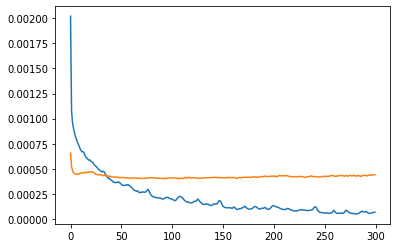

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Save the model

In [16]:
model.save('RainNet.h5')